# 1 概述

再来回忆一下我们的终极目标，我们的终极目标是搭建一个人脸识别的模型，经过之前的努力，我们已经训练出来了一个人脸检测模型，然后我们就可以利用检测到的人脸，将其输入人脸识别模型中，来达到人脸识别的目的。

现在有一个问题，之前的人脸检测模型是通过darknet平台实现的，但是接下来的人脸识别模型我们不会使用darknet网络了，而会使用keras+tensorflow，为了整个模型的灵活性，也为了更好的管理人脸识别模型，我们需要将darknet移植出来，用Python来实现。当然并不会抑制整个darknet平台，仅仅移植和YOLO相关的部分，当然，我也不会自己动手去移植，因为已经有人已经帮助我们做好了这些事情！

所以接下来，我们将使用[YAD2K](https://github.com/allanzelener/YAD2K)这个开源工程，其实就是darknet的Python版本，但是支持的模型仅仅是类YOLO的模型（tiny-yolo等）。

所以darknet在本项目中就是为了训练YOLO人脸检测模型的权重，然后我们利用YAD2K来搭建YOLO人脸检测模型，加载权重。最后再搭建人脸识别模型。

# 2 YAD2K

本项目就是基于[YAD2K](https://github.com/allanzelener/YAD2K)上进行开发的，所以你没必要再去克隆。再声明一点，本notebook就位于YAD2K内。

接下来我们就来走一遍YAD2K的流程，看看他到底做了哪些事情。然后我们再提取我们需要的部分来搭建YOLO模型！

## 2.1 YAD2K运行环境搭建

首先根据YAD2K的使用说明来搭建环境，输入如下命令

    git clone https://github.com/allanzelener/yad2k.git
    cd yad2k
    
    ## 为了方便，作者把yad2k的环境信息都放在了environment.yml文件里面，运行下面的命令创建环境
    conda env create -f environment.yml
    source activate yad2k
    
    # 安装一些常用的库
    pip install numpy h5py pillow
    # 安装GPU版本的tensorflow，如果没有GPU的话，安装CPU版本的也可以，就是CPU版本的预测的速度要慢很多
    pip install tensorflow-gpu  # CPU-only: conda install -c conda-forge tensorflow
    pip install keras # Possibly older release: conda install keras

## 2.2 YOLO模型配置文件以及权重

就像之前[第二个notebook](https://github.com/rikichou/yolo/blob/master/YOLO_face_detection_and_recognition_2--train_yolo_on_CelebA_datasheet.ipynb)说的那样，darknet需要一个模型的配置文件和权重才能把模型搭建起来，同理，对于YAD2K也需要这两样东西。

    1，YOLO模型配置文件，本git已经自带，位于cfg/yolov2-celeba.cfg
    2，权重文件是我们在CelebA数据集上训练的权重，有大概200M，我放在了另一个仓库里面，记得克隆前要安装git LFS
        git lfs clone https://github.com/rikizhou/yolo_face_weights.git
      下载完了把它拷贝到weights目录下就可以了

## 2.3 转换darknet模型

在上一步中，我们获得darknet下载YOLO模型的配置文件和权重，这两样东西包含了搭建模型需要的全部东西。现在我们就根据这两样东西，将darknet模型转换为keras模型。

注意注意！各位同学！！！这里需要更改源码的一个BUG，在yad2k.py，在第 83 行，将 buffer=weights_file.read(16) 改为 buffer=weights_file.read(20)，否则会出现权重错位，导致模型完全错误！当然，在本项目中，已经更改好了！

./yad2k.py cfg/yolov2-celeba.cfg weights/yolov2-celeba_5000.weights model_data/yolo_face_detectoin.h5

运行了之后，会在model_data目录下生成yolo_face_detectoin_anchors.txt文件

## 2.4 预测测试图片

YAD2K是利用test_yolo.py这个文件来实现预测的，所以我们应该查看其源代码，分析该脚本需要提供什么参数？
    
    model_path：keras模型的路径，model_data/yolo_face_detectoin.h5
    --anchors_path：我们需要指定anchors文件的路径，model_data/yolo_face_detectoin_anchors.txt
    --classes_path：类别文件的路径，里面指定了每个类别的名字，我们就只有一个face，model_data/celeba_classes.txt
    --test_path：输入的测试图片的路径，默认是在images目录下，我们就用默认的就好了
    --output_path：输出的测试图片的路径，默认在images/out，我们就用默认
    --score_threshold：将每个anchors的pc乘以该anchors的类别概率就等于scores，对于YOLO模型的预测输出，如果某个anchors的score小于score_threshold，那么该anchors的预测将直接会被删除，不会参与IOU的流程。默认为0.3，我们暂时使用0.3，然后根据效果来调节该阈值。
    --iou_threshold：IOU的阈值，在执行非最大值抑制（NMS）的时候，如果两个同类预测的bbox的IOU>iou_threshold，那么就认为该对象被重复检测了，需要删除几率小的那个Bbox。默认为0.5，我们暂时使用0.5，然后根据效果来调节该阈值。
    
如果我上面说的这些大家不懂的话，那么可能需要看关于YOLO的视频了，这里推荐吴恩达教授Coursera上的DeepLearning.ai系列课程，在CNN部分讲解了YOLO的详细流程。

接下来我们就要预测一下images里面的图片，输出的结果在images/out文件夹里面

./test_yolo.py model_data/yolo_face_detectoin.h5 -a model_data/yolo_face_detectoin_anchors.txt -c model_data/celeba_classes.txt

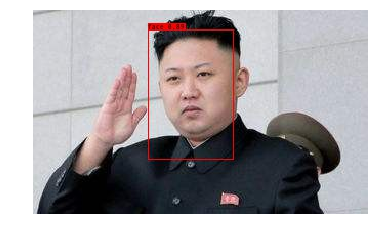

In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
img_path = "images/out/timg.jpeg"

plt.figure(figsize=(6,6))

img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

# 3 我们需要怎样的接口

经过上面的对图片的预测，我们可以基本判定我们需要什么样的接口了，一个接口用于根据传入的配置创建模型，另一个接口用于预测输入的图片，输出图片的所有的bounding box以及所有的bounding box属于脸的概率。

所以，我们可以创建一个类，如下代码：

In [17]:
import configparser
import io
import os
from collections import defaultdict
import colorsys
import imghdr
import random
import numpy as np
from keras import backend as K
from PIL import Image, ImageDraw, ImageFont

from keras.layers import (Conv2D, GlobalAveragePooling2D, Input, Lambda,
                          MaxPooling2D)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model as plot
from yad2k.models.keras_yolo import yolo_eval, yolo_head
from yad2k.models.keras_yolo import (space_to_depth_x2,
                                     space_to_depth_x2_output_shape)
 
default_config_path = "cfg/yolov2-celeba.cfg"
default_weights_path = "weights/yolov2-celeba_5000.weights"
default_anchors_path = "model_data/yolo_face_detectoin_anchors.txt"
default_classes_path = "model_data/celeba_classes.txt"
default_score_threshold = 0.3
default_iou_threshold = 0.5

class Detector(object):
    def __init__(self, config_path=default_config_path, weights_path=default_weights_path, anchors_path=default_anchors_path, \
                 classes_path = default_classes_path, score_threshold=default_score_threshold, iou_threshold=default_iou_threshold):
        self.config_path = config_path
        self.weights_path = weights_path
        self.anchors_path = anchors_path
        self.classes_path = classes_path
        self.sess = K.get_session()
        self.iou_threshold = iou_threshold
        self.score_threshold = score_threshold
        
        output_root = "model_data"
        print('Loading weights.')
        
        # Load weights and config.
        weights_file = open(weights_path, 'rb')
        weights_header = np.ndarray(
            shape=(4, ), dtype='int32', buffer=weights_file.read(20))
        
        unique_config_file = self.unique_config_sections(self.config_path)
        cfg_parser = configparser.ConfigParser()
        cfg_parser.read_file(unique_config_file)
        
        image_height = int(cfg_parser['net_0']['height'])
        image_width = int(cfg_parser['net_0']['width'])
        self.image_height = image_height
        self.image_width = image_width
        prev_layer = Input(shape=(image_height, image_width, 3))
        all_layers = [prev_layer]

        weight_decay = float(cfg_parser['net_0']['decay']
                             ) if 'net_0' in cfg_parser.sections() else 5e-4
        count = 0
        
        for section in cfg_parser.sections():
            print('Parsing section {}'.format(section))
            if section.startswith('convolutional'):
                filters = int(cfg_parser[section]['filters'])
                size = int(cfg_parser[section]['size'])
                stride = int(cfg_parser[section]['stride'])
                pad = int(cfg_parser[section]['pad'])
                activation = cfg_parser[section]['activation']
                batch_normalize = 'batch_normalize' in cfg_parser[section]

                # padding='same' is equivalent to Darknet pad=1
                padding = 'same' if pad == 1 else 'valid'

                # Setting weights.
                # Darknet serializes convolutional weights as:
                # [bias/beta, [gamma, mean, variance], conv_weights]
                prev_layer_shape = K.int_shape(prev_layer)

                # TODO: This assumes channel last dim_ordering.
                weights_shape = (size, size, prev_layer_shape[-1], filters)
                darknet_w_shape = (filters, weights_shape[2], size, size)
                weights_size = np.product(weights_shape)

                print('conv2d', 'bn'
                      if batch_normalize else '  ', activation, weights_shape)

                conv_bias = np.ndarray(
                    shape=(filters, ),
                    dtype='float32',
                    buffer=weights_file.read(filters * 4))
                count += filters

                if batch_normalize:
                    bn_weights = np.ndarray(
                        shape=(3, filters),
                        dtype='float32',
                        buffer=weights_file.read(filters * 12))
                    count += 3 * filters

                    # TODO: Keras BatchNormalization mistakenly refers to var
                    # as std.
                    bn_weight_list = [
                        bn_weights[0],  # scale gamma
                        conv_bias,  # shift beta
                        bn_weights[1],  # running mean
                        bn_weights[2]  # running var
                    ]

                conv_weights = np.ndarray(
                    shape=darknet_w_shape,
                    dtype='float32',
                    buffer=weights_file.read(weights_size * 4))
                count += weights_size

                # DarkNet conv_weights are serialized Caffe-style:
                # (out_dim, in_dim, height, width)
                # We would like to set these to Tensorflow order:
                # (height, width, in_dim, out_dim)
                # TODO: Add check for Theano dim ordering.
                conv_weights = np.transpose(conv_weights, [2, 3, 1, 0])
                conv_weights = [conv_weights] if batch_normalize else [
                    conv_weights, conv_bias
                ]

                # Handle activation.
                act_fn = None
                if activation == 'leaky':
                    pass  # Add advanced activation later.
                elif activation != 'linear':
                    raise ValueError(
                        'Unknown activation function `{}` in section {}'.format(
                            activation, section))

                # Create Conv2D layer
                conv_layer = (Conv2D(
                    filters, (size, size),
                    strides=(stride, stride),
                    kernel_regularizer=l2(weight_decay),
                    use_bias=not batch_normalize,
                    weights=conv_weights,
                    activation=act_fn,
                    padding=padding))(prev_layer)

                if batch_normalize:
                    conv_layer = (BatchNormalization(
                        weights=bn_weight_list))(conv_layer)
                prev_layer = conv_layer

                if activation == 'linear':
                    all_layers.append(prev_layer)
                elif activation == 'leaky':
                    act_layer = LeakyReLU(alpha=0.1)(prev_layer)
                    prev_layer = act_layer
                    all_layers.append(act_layer)

            elif section.startswith('maxpool'):
                size = int(cfg_parser[section]['size'])
                stride = int(cfg_parser[section]['stride'])
                all_layers.append(
                    MaxPooling2D(
                        padding='same',
                        pool_size=(size, size),
                        strides=(stride, stride))(prev_layer))
                prev_layer = all_layers[-1]

            elif section.startswith('avgpool'):
                if cfg_parser.items(section) != []:
                    raise ValueError('{} with params unsupported.'.format(section))
                all_layers.append(GlobalAveragePooling2D()(prev_layer))
                prev_layer = all_layers[-1]

            elif section.startswith('route'):
                ids = [int(i) for i in cfg_parser[section]['layers'].split(',')]
                layers = [all_layers[i] for i in ids]
                if len(layers) > 1:
                    print('Concatenating route layers:', layers)
                    concatenate_layer = concatenate(layers)
                    all_layers.append(concatenate_layer)
                    prev_layer = concatenate_layer
                else:
                    skip_layer = layers[0]  # only one layer to route
                    all_layers.append(skip_layer)
                    prev_layer = skip_layer

            elif section.startswith('reorg'):
                block_size = int(cfg_parser[section]['stride'])
                assert block_size == 2, 'Only reorg with stride 2 supported.'
                all_layers.append(
                    Lambda(
                        space_to_depth_x2,
                        output_shape=space_to_depth_x2_output_shape,
                        name='space_to_depth_x2')(prev_layer))
                prev_layer = all_layers[-1]

            elif section.startswith('region'):
                with open('{}_anchors.txt'.format(output_root), 'w') as f:
                    print(cfg_parser[section]['anchors'], file=f)

            elif (section.startswith('net') or section.startswith('cost') or
                  section.startswith('softmax')):
                pass  # Configs not currently handled during model definition.

            else:
                raise ValueError(
                    'Unsupported section header type: {}'.format(section))
            
        self.model = Model(inputs=all_layers[0], outputs=all_layers[-1])
        print(self.model.summary())
        remaining_weights = len(weights_file.read()) / 4
        weights_file.close()
        print('Read {} of {} from Darknet weights.'.format(count, count +
                                                           remaining_weights))
        if remaining_weights > 0:
            print('Warning: {} unused weights'.format(remaining_weights))
    
        """
        =========================================================================
        """
        with open(self.classes_path) as f:
            class_names = f.readlines()
        self.class_names = [c.strip() for c in class_names]

        with open(self.anchors_path) as f:
            anchors = f.readline()
            anchors = [float(x) for x in anchors.split(',')]
            self.anchors = np.array(anchors).reshape(-1, 2)
        
        # Verify model, anchors, and classes are compatible
        num_classes = len(self.class_names)
        num_anchors = len(self.anchors)
        # TODO: Assumes dim ordering is channel last
        model_output_channels = self.model.layers[-1].output_shape[-1]
        assert model_output_channels == num_anchors * (num_classes + 5), \
            'Mismatch between model and given anchor and class sizes. ' \
            'Specify matching anchors and classes with --anchors_path and ' \
            '--classes_path flags.'
        
        ##### check if need
        # Check if model is fully convolutional, assuming channel last order.
        self.model_image_size = self.model.layers[0].input_shape[1:3]
        is_fixed_size = self.model_image_size != (None, None)

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                colors))
        random.seed(10101)  # Fixed seed for consistent colors across runs.
        random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
        random.seed(None)  # Reset seed to default.
        ##### check if need
        
        # Generate output tensor targets for filtered bounding boxes.
        # TODO: Wrap these backend operations with Keras layers.
        yolo_outputs = yolo_head(self.model.output, self.anchors, len(self.class_names))
        self.input_image_shape = K.placeholder(shape=(2, ))
        self.boxes, self.scores, self.classes = yolo_eval(
            yolo_outputs,
            self.input_image_shape,
            score_threshold=self.score_threshold,
            iou_threshold=self.iou_threshold)
        
    def predict(self, image):
        """
            input : np array, h,w,c
        """
        h, w, c = image.shape
        image_data = np.array(image, np.float32)
        image_data = cv2.resize(image_data, (self.image_height, self.image_width))
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
        
        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.model.input: image_data,
                self.input_image_shape: [h, w],
                K.learning_phase(): 0
            })
        
        print('Found {} boxes for image'.format(len(out_boxes)))
        
        crop_imgs = []
        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            top, left, bottom, right = box
            print (label + "top:{} left:{} bottom:{} right:{}".format(top, left, bottom, right))
            
            item = image[int(top):int(bottom), int(left):int(right), :]
            crop_imgs.append(item)
        return crop_imgs   
        
    def unique_config_sections(self, config_file):
        """Convert all config sections to have unique names.
        Adds unique suffixes to config sections for compability with configparser.
        """
        section_counters = defaultdict(int)
        output_stream = io.StringIO()
        with open(config_file) as fin:
            for line in fin:
                if line.startswith('['):
                    section = line.strip().strip('[]')
                    _section = section + '_' + str(section_counters[section])
                    section_counters[section] += 1
                    line = line.replace(section, _section)
                output_stream.write(line)
        output_stream.seek(0)
        return output_stream


In [18]:
a = Detector()

Loading weights.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)
Parsing section maxpool_0
Parsing section convolutional_1
conv2d bn leaky (3, 3, 32, 64)
Parsing section maxpool_1
Parsing section convolutional_2
conv2d bn leaky (3, 3, 64, 128)
Parsing section convolutional_3
conv2d bn leaky (1, 1, 128, 64)
Parsing section convolutional_4
conv2d bn leaky (3, 3, 64, 128)
Parsing section maxpool_2
Parsing section convolutional_5
conv2d bn leaky (3, 3, 128, 256)
Parsing section convolutional_6
conv2d bn leaky (1, 1, 256, 128)
Parsing section convolutional_7
conv2d bn leaky (3, 3, 128, 256)
Parsing section maxpool_3
Parsing section convolutional_8
conv2d bn leaky (3, 3, 256, 512)
Parsing section convolutional_9
conv2d bn leaky (1, 1, 512, 256)
Parsing section convolutional_10
conv2d bn leaky (3, 3, 256, 512)
Parsing section convolutional_11
conv2d bn leaky (1, 1, 512, 256)
Parsing section convolutional_12
conv2d bn leaky (3, 3, 256, 512)
Parsing section m

after non_max_suppression Tensor("Shape_38:0", shape=(1,), dtype=int32)
after gather Tensor("Shape_39:0", shape=(2,), dtype=int32)


Found 1 boxes for image
face 0.89top:19.60515022277832 left:111.8637924194336 bottom:144.1929168701172 right:194.84368896484375


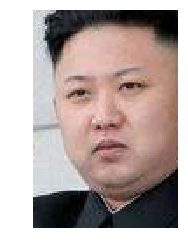

In [19]:
import cv2
import matplotlib.pyplot as plt

img_path = "images/timg.jpeg"

img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

crop_imgs = a.predict(img)
plt.imshow(crop_imgs[0])
plt.axis("off")
plt.show()

明天开始写人脸识别的接口，写完了之后就可以衔接起来了。最后再显示人脸识别的结果和人脸检测的结果！